In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
class PlantDiseaseDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load the image and apply transformations
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)


def load_images(directory_root):
    image_list, label_list = [], []
    print("[INFO] Loading images...")

    for disease_folder in os.listdir(directory_root):
        disease_folder_path = os.path.join(directory_root, disease_folder)
        if not os.path.isdir(disease_folder_path):
            continue

        for img_name in os.listdir(disease_folder_path):
            if img_name.startswith("."):
                continue
            img_path = os.path.join(disease_folder_path, img_name)
            if img_path.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_list.append(img_path)
                label_list.append(disease_folder)
    
    print("[INFO] Image loading completed")
    print(f"Total images: {len(image_list)}")
    return image_list, label_list

# Load images and labels
directory_root = "/kaggle/input/plantdisease/PlantVillage"
image_paths, labels = load_images(directory_root)

# Encode labels as integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Train, validation, and test splits
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels_encoded, test_size=0.3, random_state=42, stratify=labels_encoded
)
valid_paths, test_paths, valid_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(valid_paths)}")
print(f"Test samples: {len(test_paths)}")


[INFO] Loading images...
[INFO] Image loading completed
Total images: 20638
Training samples: 14446
Validation samples: 3096
Test samples: 3096


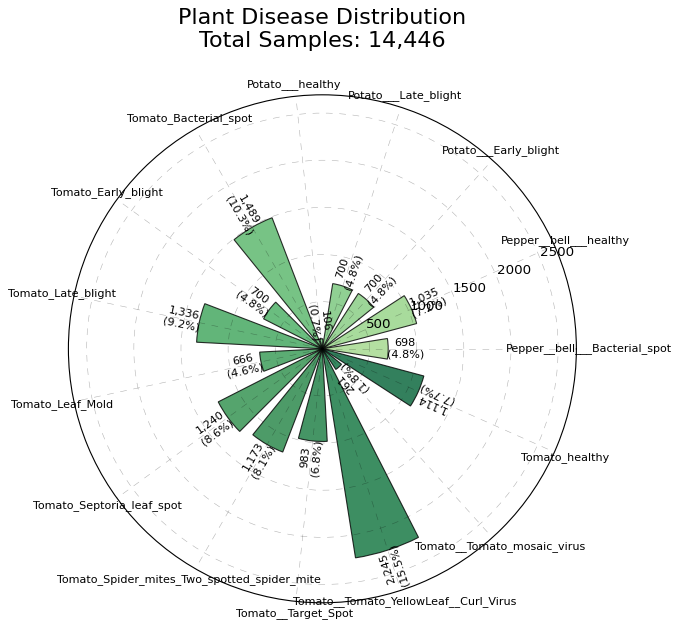

In [3]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np

def visualize_class_distribution(labels, class_names):
    class_counts = Counter(labels)
    sorted_counts = sorted(class_counts.items(), key=lambda x: x[0])
    counts = [count for _, count in sorted_counts]
    class_labels = [class_names[idx] for idx, _ in sorted_counts]
    percentages = [count/len(labels)*100 for count in counts]
    
    plt.figure(figsize=(10,8))
    ax = plt.subplot(111, projection='polar')
    angles = np.linspace(0, 2*np.pi, len(counts), endpoint=False)
    colors = plt.cm.YlGn(np.linspace(0.4, 0.9, len(counts)))
    bars = ax.bar(angles, counts, width=2*np.pi/len(counts)*0.75, alpha=0.8, color=colors)
    
    for angle, count, percentage in zip(angles, counts, percentages):
        label_radius = count + (max(counts) * 0.08)
        label = f'{count:,}\n({percentage:.1f}%)'
        ax.text(angle, label_radius, label, ha='center', va='center', fontsize=10,
                rotation=np.degrees(angle) if -90 <= np.degrees(angle) <= 90 else np.degrees(angle) + 180)
    
    ax.set_title('Plant Disease Distribution\nTotal Samples: {:,}'.format(sum(counts)), y=1.05, fontsize=20, pad=20)
    ax.set_xticks(angles)
    ax.set_xticklabels(class_labels, fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.set_ylim(0, max(counts) * 1.2)
    plt.tight_layout()
    plt.show()

plt.style.use('classic')
plt.rcParams['figure.facecolor'] = 'white'
visualize_class_distribution(train_labels, label_encoder.classes_)

In [26]:
# Data Transformations
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),           # Data augmentation for training
    transforms.RandomRotation(30),              # Random rotation for variability
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization
])

valid_test_transform = transforms.Compose([
    transforms.Resize((256, 256)),              # Consistent resizing for validation/test
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Same normalization as training
])

# Create datasets with appropriate transformations
train_dataset = PlantDiseaseDataset(train_paths, train_labels, transform=train_transform)
valid_dataset = PlantDiseaseDataset(valid_paths, valid_labels, transform=valid_test_transform)
test_dataset = PlantDiseaseDataset(test_paths, test_labels, transform=valid_test_transform)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # Shuffle for training
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False) # No shuffle for validation/test
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)   # No shuffle for test


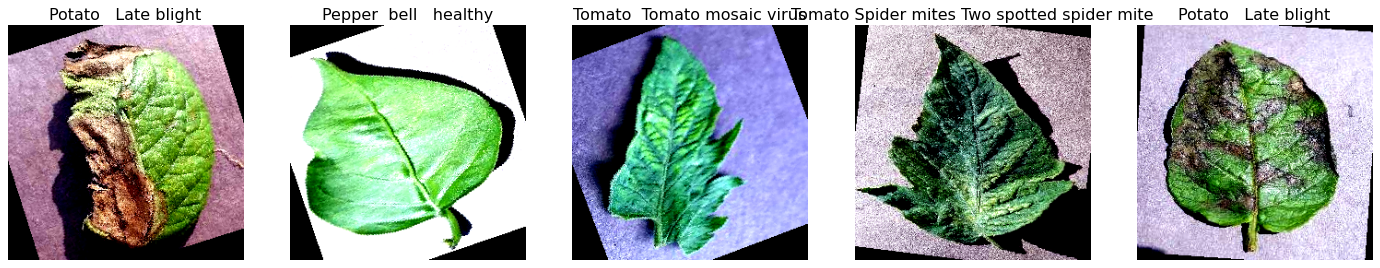

In [27]:
def visualize_samples(dataset, num_samples=5):
    plt.figure(figsize=(22, 5))
    for i in range(num_samples):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()
        img = (img * 0.5) + 0.5  # De-normalize
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(label_encoder.inverse_transform([label])[0].replace('_',' '))  # Convert label back to class name
        plt.axis('off')
    plt.show()

visualize_samples(train_dataset)

In [28]:
for inputs, labels in test_loader:
    print(f"Batch inputs shape: {inputs.shape}")  # Should be [batch_size, 3, 128, 128]
    print(f"Batch labels shape: {labels.shape}")  # Should be [batch_size]
    print(f"First 5 samples labels: {labels[:5]}")   # Print first 5 labels
    break

Batch inputs shape: torch.Size([32, 3, 256, 256])
Batch labels shape: torch.Size([32])
First 5 samples labels: tensor([11,  2, 14, 12, 11])


In [29]:
class PlantDiseaseModel(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseModel, self).__init__()
        # Convolutional Block 1
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Output: 32x128x128 (assuming input is 3x256x256)
        )
        # Convolutional Block 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Output: 64x64x64
        )
        # Convolutional Block 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Output: 128x32x32
        )
        # Convolutional Block 4
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding="same"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Output: 256x16x16
        )
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Output: 256x1x1
        # Fully Connected Layers
        self.fc_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),  # Adjusted input size after GAP
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.global_avg_pool(x)
        x = self.fc_block(x)
        return x


In [30]:
# Initialize model, loss, optimizer
num_classes = len(label_encoder.classes_)
print(f"Number of Classes: {num_classes}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device Used: {device}")

model = PlantDiseaseModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002)

Number of Classes: 15
Device Used: cuda


In [31]:
from torchsummary import summary
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
        MaxPool2d-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-14          [-1, 256,

In [32]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, save_path="best_model.pth"):
        self.patience = patience
        self.min_delta = min_delta
        self.save_path = save_path
        self.best_loss = float('inf')
        self.counter = 0

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.save_path)  # Save the best model
            print(f"[INFO] Model checkpoint saved to {self.save_path}")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("[INFO] Early stopping triggered.")
                return True
        return False

def evaluate_model(model, data_loader, criterion):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(data_loader)
    accuracy = correct / total * 100
    return val_loss, accuracy
    

def train_model(
    model, train_loader, valid_loader, criterion, optimizer, epochs, early_stopping=None):
    train_losses, valid_losses, valid_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), desc=f"Epoch {epoch+1}/{epochs}", total=len(train_loader))

        for batch_idx, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({"Train Loss": loss.item()})

        # Record training loss
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation step
        val_loss, val_accuracy = evaluate_model(model, valid_loader, criterion)
        valid_losses.append(val_loss)
        valid_accuracies.append(val_accuracy)

        # Print epoch summary
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_accuracy:.2f}%")

        # Early stopping
        if early_stopping and early_stopping(val_loss, model):
            print("[INFO] Early stopping triggered.")
            break

    return train_losses, valid_losses, valid_accuracies


In [ ]:
n_epochs = 100

early_stopping = EarlyStopping(patience=4, min_delta=0.01, save_path="best_model.pth")
train_losses, valid_losses, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, epochs=n_epochs, early_stopping=early_stopping
)

Epoch 1/100: 100%|██████████| 452/452 [02:06<00:00,  3.57it/s, Train Loss=2.39]


Epoch 1: Train Loss = 2.4252, Val Loss = 2.1902, Val Accuracy = 32.40%
[INFO] Model checkpoint saved to best_model.pth


Epoch 2/100: 100%|██████████| 452/452 [01:14<00:00,  6.06it/s, Train Loss=2.4] 


Epoch 2: Train Loss = 2.0980, Val Loss = 1.9273, Val Accuracy = 42.73%
[INFO] Model checkpoint saved to best_model.pth


Epoch 3/100: 100%|██████████| 452/452 [01:12<00:00,  6.21it/s, Train Loss=1.91]


Epoch 3: Train Loss = 1.8944, Val Loss = 1.7184, Val Accuracy = 48.90%
[INFO] Model checkpoint saved to best_model.pth


Epoch 4/100: 100%|██████████| 452/452 [01:12<00:00,  6.26it/s, Train Loss=2.11]


Epoch 4: Train Loss = 1.7240, Val Loss = 1.5496, Val Accuracy = 56.40%
[INFO] Model checkpoint saved to best_model.pth


Epoch 5/100: 100%|██████████| 452/452 [01:10<00:00,  6.37it/s, Train Loss=1.64] 


Epoch 5: Train Loss = 1.5788, Val Loss = 1.4070, Val Accuracy = 60.08%
[INFO] Model checkpoint saved to best_model.pth


Epoch 6/100: 100%|██████████| 452/452 [01:09<00:00,  6.46it/s, Train Loss=1.37]


Epoch 6: Train Loss = 1.4593, Val Loss = 1.2773, Val Accuracy = 64.08%
[INFO] Model checkpoint saved to best_model.pth


Epoch 7/100:  15%|█▌        | 69/452 [00:10<00:59,  6.42it/s, Train Loss=1.32]

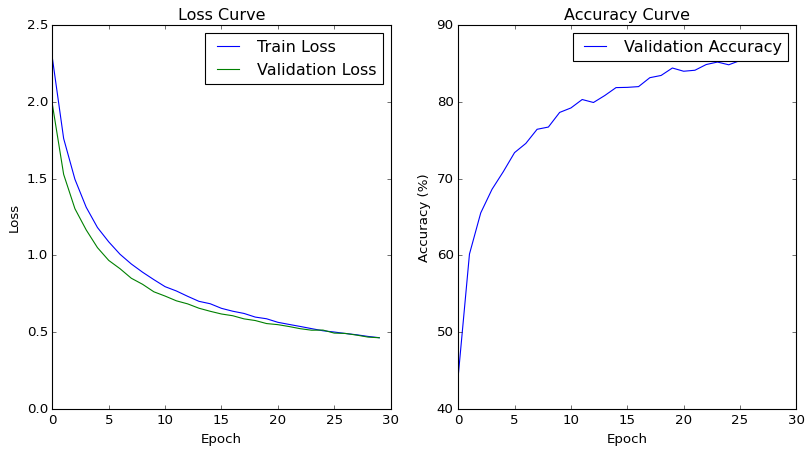

In [13]:
def plot_learning_curve(train_losses, valid_losses, valid_accuracies):
    plt.figure(figsize=(12, 6))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(valid_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(valid_accuracies, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.show()

plot_learning_curve(train_losses, valid_losses, valid_accuracies)

In [14]:
# Load the best model
model.load_state_dict(torch.load("best_model.pth"))
print("[INFO] Best model loaded for final evaluation.")

final_val_loss, final_val_accuracy = evaluate_model(model, test_loader, criterion)
print(f"Final Evaluation -> Val Loss: {final_val_loss:.4f}, Val Accuracy: {final_val_accuracy:.2f}%")

<ipython-input-14-918201ad6c24>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


[INFO] Best model loaded for final evaluation.
Final Evaluation -> Val Loss: 0.4347, Val Accuracy: 86.60%


In [16]:
import os
import shutil
import json

os.makedirs("kaggle_model_dataset", exist_ok=True)

!pip install -q kaggle

# Set your Kaggle API credentials
os.environ['KAGGLE_USERNAME'] = 'sayedgamal99'
os.environ['KAGGLE_KEY'] = '63cfc19bdc97320cfcc77d6fa62e2821'

# Move the model to the correct folder
shutil.move("best_model.pth", "kaggle_model_dataset/disease_classifier.pth")

# Metadata for your dataset
metadata = {
    "title": "Plant Disease Classifier (CNN)",  # Keep the title the same as the existing dataset
    "id": "sayedgamal99/disease-classifier",  # The ID for your dataset
    "licenses": [{"name": "CC0-1.0"}]
}

# Save the metadata file
with open("kaggle_model_dataset/dataset-metadata.json", "w") as f:
    json.dump(metadata, f)

# Now, to update the existing dataset, use the 'version' command
!kaggle datasets version -p kaggle_model_dataset -m "Updated model with new version" 


Starting upload for file disease_classifier.pth
100%|██████████████████████████████████████| 32.4M/32.4M [00:00<00:00, 94.6MB/s]
Upload successful: disease_classifier.pth (32MB)
Dataset version is being created. Please check progress at https://www.kaggle.com/sayedgamal99/disease-classifier
